# **Genomic Data Clustering**

The discovery of *DNA (Deoxyribonucleic Acid)*, and the critical role it plays in information storage for all biological beings, was a seminal moment for the biological sciences. All the information that is needed for the functioning of a living cell is encoded in and ultimately derived from the DNA of that cell, and this holds true for all biological organisms on the planet.

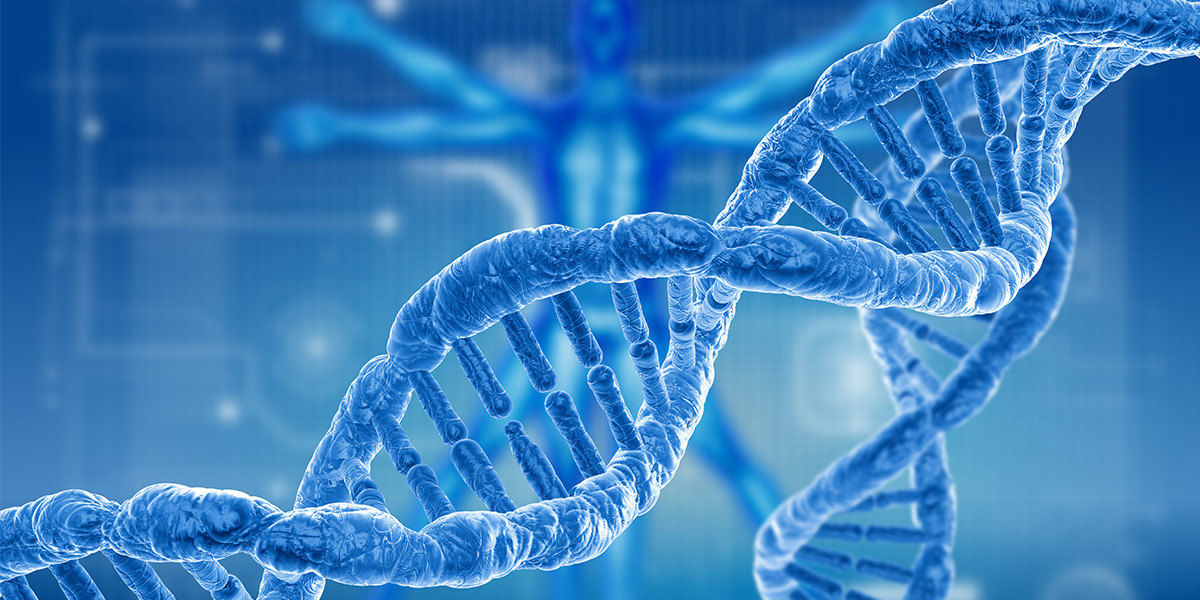


**DNA can be represented as a text sequence, with an alphabet that only has four letters** - A (Adenosine), C (Cytosine), G (Guanine) and T (Thymine). The diversity of living organisms and their complex properties is hidden in their genomic sequences. One of the most exciting problems in modern science is to understand the organization of living matter by reading genomic sequences. 

One distinctive message in a genomic sequence is a piece of text, called a **gene**. Genes can be oriented in the sequence in either the forward or backward directions. In the highest organisms (humans, for example), the notion of a gene is more complex. 

It was one of the many great discoveries of the *Twentieth century*, that biological information is encoded in genes by means of **triplets of letters**, **called codons** in the biological literature. 

In this project, I will find out if it is possible to **verify the validity of the discovery of three-letter codons**, by performing unsupervised machine learning on the genetic sequence.

## **Goal**

The work starts with a fragment of the genomic sequence of the bacterium **Caulobacter Crescentus**. This sequence is given as a long text file (300 kb), and the task is to look at the file and ensure that the text uses the alphabet of four letters (A, C, G and T), and that these letters are used without spaces.

In this case study, I accept data from a genome and have the goal of identifying useful genes versus noise. Unfortunately, I don't know which sequences of genes are useful, so I will have to use Unsupervised Learning to infer this. 

In this notebook I walk through the following series of steps:

  1. First, the data is imported and prepared. Initially the sequence, a single string, is split into non-overlapping substrings of length 300, and the combinations of the distinct 1, 2, 3, and 4-length sequences of base pairs which appear in each possible substring are counted.
  2. PCA is performed to try to identify the internal structure of the data.
  3. Finally, if PCA reveals some internal structure, then I will apply Clustering techniques to the dataset.

In [18]:
# Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

The file format often used for bioinformatics and genomic data is called **FASTA**. It is a normally encoded file with headers separating genetic information. I read the file. 

There are a lot of lines in this file. I will use the line.strip() to strip all empty spaces and then store them in a variable called `geneticCode`.

Next, I will count the number of a,g,t, and c characters (genome).

### Is this sequence similar to a Human DNA?

In [9]:
# Open the file and get an array of its lines 
with open ("ccrescentus.fa", "r") as inputFile:
    data = inputFile.readlines()

# Concatenate each line from the second line (first line is a description), stripped of empty chars 
geneticCode = ''
for line in data[1:]:
    geneticCode += line.strip()
    
print("Length of the entire genetic sequence is:", len(geneticCode))
    
# Count the presence of each genome (a,g,t,c)
aCount = geneticCode.count('a')
gCount = geneticCode.count('g')
tCount = geneticCode.count('t')
cCount = geneticCode.count('c')

# Print a sample of the string and check if there are only wanted characters
print("First 30 characters in the entire genetic sequence:", geneticCode[0:30])
print('Test: only a,g,t,c ?')
print("Does the sequence contain only a,g,t, and c characters? ", aCount + gCount + tCount + cCount == len(geneticCode))

Length of the entire genetic sequence is: 305100
First 30 characters in the entire genetic sequence: gccgatagcctatgatccccggcaggcccg
Test: only a,g,t,c ?
Does the sequence contain only a,g,t, and c characters?  True


* These are the `first 30 characters` of the genetic sequence for this bacteria. Human DNA has only a,g,t and c. 
* The final part of the code basically tests whether the sum of counts of a,g,t, and c is equal to the length of the genetic sequence. 
* This means that the entire sequence is made up of only a,g,t and c- and that `is similar to that of a human DNA`, which is pretty awesome!

## **Converting Text to a Numerical Table**

#### **Creating Frequency Tables**
* Now I got a string element containing the sequence. A **word** is `any continuous piece of text` that contains several subsequent letters. As there are `no spaces` in the text, `separation into words` is not unique. I do not know whether the words should be long or short, or how many characters represent each word.

* What I will do is `separate the sequence into smaller sub-strings` and create `frequency tables` for `each x-sized word`. I will start by separating the string into a number of sub-strings, of a `reasonable sample size`, to become rows on the table.


* Knowing that the string has `305,100 characters`, I will check for words with a `maximum of 4 - 5 letters`, else it might become too long. I split it into groups of 300. It generates 1k data points, and allows for **60 5-letter words**. 

* I will clip the whole text into `fragments of 300 letters`, `4 in length` and calculate the `frequencies of short words` (of length 1–4) inside every fragment. This will give me a description of the text in the form of a numerical table. There will be four such tables for every short word length choice from 1 to 4. 

* As there are only four letters, there are four possible words of length 1 (singlets), 16 = 4^2 possible words of length 2 (duplets), 64 = 4^3 possible words of length 3 (triplets) and 256 = 4^4 possible words of length 4 (quadruplets).

* The first table contains four columns (frequency of every singlet) and the number of rows equals the number of fragments. The second table has 16 columns and the same number of rows, and so on. 

In [19]:
# Size of the groups/fragments 
size = 300

# Empty Array
dataPoints = []

# Copy the entire code into a string, which will be removed of its first elements iteratively
tempString = geneticCode

# Iteratively remove a left chunk of the string and place it into the array
while len(tempString) > 0:
    dataPoints.append(tempString[0:size])
    tempString = tempString[size:]

# Print first fragment
print(dataPoints[0])

gccgatagcctatgatccccggcaggcccggggcttggagccgtctggtttggatggaaccctccaaaccagatcaagaggctcctagaacgccgcccgcagggtcacgccccaggtgcgcgggtcgcccggctggccggcgatcaggccggtgttgctgggacccacggccagttgctcgaaatagttctcgtcgaaggcgttgcggacccaggcatagaggttcagcccctcaggcgtgcggaagccggcccggaagttagcgatcgtgtagccgtcaacccaggtgtagatcgaggg


### Creating a list with the combinations of words possible

In [21]:
import itertools

# Create list of iterables
iterables = ['a','g','t','c']

#Create empty dictionary
wordsDict =  {}

# Calculate the Cartesian Product to get all possibilities of words for lengths 1,2,3, and 4
for i in range(1,5):
    words = []
    iterator = itertools.product(iterables, repeat = i)
    for word in iterator:
        s = ''
        for t in word:
            s += t
        words.append(s)
    wordsDict[i] = words
    
# Print the dictionary
print(wordsDict)

# Print the dictionary for 3 letter words (hence the square braces has the number 3)
print(wordsDict[3])
print(len(wordsDict[3]))

{1: ['a', 'g', 't', 'c'], 2: ['aa', 'ag', 'at', 'ac', 'ga', 'gg', 'gt', 'gc', 'ta', 'tg', 'tt', 'tc', 'ca', 'cg', 'ct', 'cc'], 3: ['aaa', 'aag', 'aat', 'aac', 'aga', 'agg', 'agt', 'agc', 'ata', 'atg', 'att', 'atc', 'aca', 'acg', 'act', 'acc', 'gaa', 'gag', 'gat', 'gac', 'gga', 'ggg', 'ggt', 'ggc', 'gta', 'gtg', 'gtt', 'gtc', 'gca', 'gcg', 'gct', 'gcc', 'taa', 'tag', 'tat', 'tac', 'tga', 'tgg', 'tgt', 'tgc', 'tta', 'ttg', 'ttt', 'ttc', 'tca', 'tcg', 'tct', 'tcc', 'caa', 'cag', 'cat', 'cac', 'cga', 'cgg', 'cgt', 'cgc', 'cta', 'ctg', 'ctt', 'ctc', 'cca', 'ccg', 'cct', 'ccc'], 4: ['aaaa', 'aaag', 'aaat', 'aaac', 'aaga', 'aagg', 'aagt', 'aagc', 'aata', 'aatg', 'aatt', 'aatc', 'aaca', 'aacg', 'aact', 'aacc', 'agaa', 'agag', 'agat', 'agac', 'agga', 'aggg', 'aggt', 'aggc', 'agta', 'agtg', 'agtt', 'agtc', 'agca', 'agcg', 'agct', 'agcc', 'ataa', 'atag', 'atat', 'atac', 'atga', 'atgg', 'atgt', 'atgc', 'atta', 'attg', 'attt', 'attc', 'atca', 'atcg', 'atct', 'atcc', 'acaa', 'acag', 'acat', 'acac', 

* There are 64 3-letter word combinations for the letters a,c,t, and g.

* Now, I will create a **dataframe to begin the frequency matrix construction**. From there, I will apply the **count function for each word**, and store it as a new column. I do this for all the 4 sizes of words.

In [24]:
# Dictionary that will contain the frequency table for each word size
freqTables = {}

for i in range(1,5):
    
    # Create an empty DataFrame with columns being the words on the dictionary
    df = pd.DataFrame(columns = wordsDict[i])
    
    for index, dataP in enumerate(dataPoints):
        
        # Create a row with zero values corresponding to a data point
        df.loc[index] = np.zeros(len(wordsDict[i]))
        
        while len(dataP) > 0:
            
            # get the left part of the data point (i characters)
            left = dataP[0:i]
            
            # Find it in the respective column and count it there
            df.loc[index, left] += 1
            
            dataP = dataP[i:]
    
    freqTables[i] = df

# Print the head of the dataframe for 3-letter words
freqTables[3].head()

,aaa,aag,aat,aac,aga,agg,agt,agc,ata,atg,...,cgt,cgc,cta,ctg,ctt,ctc,cca,ccg,cct,ccc
0,0.0,1.0,0.0,3.0,0.0,2.0,0.0,2.0,2.0,0.0,...,2.0,2.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,1.0
1,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,5.0,0.0,...,2.0,4.0,0.0,2.0,4.0,2.0,1.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,2.0,4.0,0.0,4.0,5.0,4.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4.0,0.0,5.0,5.0,2.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,2.0,2.0,0.0,8.0,3.0,1.0,5.0,1.0,0.0,0.0


Now, **I have the data in the optimal format to run PCA.**

# **Principal Component Analysis**

- One reason why i'm trying multiple word lengths, is because without additional domain knowledge it is not clear if there are more meaningful units that I could work with than individual letters.  
- **So I calculate frequency tables to see if certain combinations happen more frequently (and more frequently together), and thus might be meaningful, than others.**
- PCA helps by creating natural clusters where combinations frequently co-occur and in reducing the dimensions also helps to visualize the dataset in a way that's otherwise not possible.

- The first step to run PCA is to **standardize the data** across columns.
- I do this to have the **same averages and dispersions across the data**, which is an important concept of both PCA and K-means, as they are distance-based algorithms.
- The **StandardScaler** package is used to achieve this.

In [13]:
# empty dictionary
normFreqTables = {}

#Standardization
for i in range(1,5):
    # Eliminate the string column from the data, leaving only the actual frequencies
    data = freqTables[i]
    data = StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(data) # copy=True make a copy of the data
    normFreqTables[i] = pd.DataFrame(data, columns = wordsDict[i])

# Check that the average of a column is close to zero and stdev close to 1(i.e. checking for normalization)
print(normFreqTables[2].loc[:, 'gt'].mean())
print(normFreqTables[2].loc[:, 'gt'].std())

-7.352361918240343e-17
1.0004920049498138


Here the mean is close to 0, and the std is 1. So, the data is standardized. 

### Principal Components and Explained Variance

In [14]:
# Principal Component Analysis with 2 components
pca = PCA(n_components = 2)

pCompTables = {}

for i in range(1,5):
    pca.fit(normFreqTables[i])
    pComponents = pca.transform(normFreqTables[i])
    # for each word size, store the result of the PCA in a table containing only the 2 princicipal components
    pCompTables[i] = pd.DataFrame(pComponents[:, [0,1]], columns = ['pc1', 'pc2'])
    print('Explained variance for ' + str(i) + ' letters: ' + str(pca.explained_variance_ratio_.sum()))

# Print PCs for words of length 3
print(pCompTables[2].head())

Explained variance for 1 letters: 0.7489363490534278
Explained variance for 2 letters: 0.22791765232139125
Explained variance for 3 letters: 0.31670201938180154
Explained variance for 4 letters: 0.02934072774713621
        pc1       pc2
0 -0.994082 -0.436191
1 -0.098276 -0.863483
2  1.176838  0.308789
3  0.552433  1.084977
4  0.082274  1.711563


Each column name of the normFreqTables is every element of the pc1 and pc2 table. If PC1 is high, maybe there are a lot of words in that combination, and low PC1 also depicts a lot of words in that combination. Similarly, for pc2. 

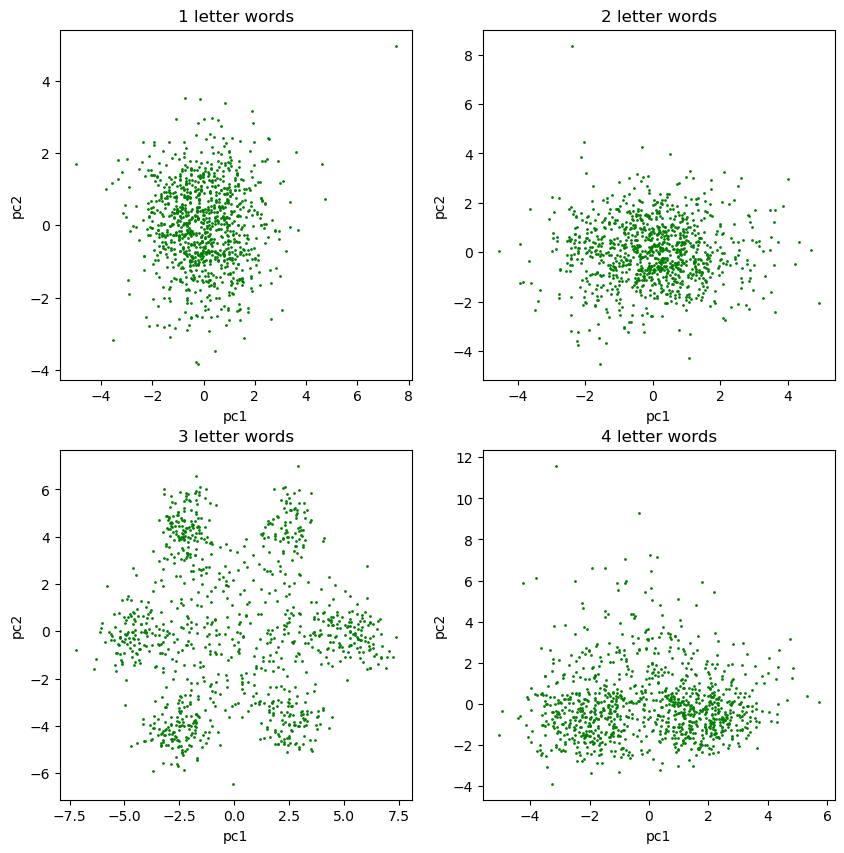

In [31]:
# Plot these tables to try to find correlations visually
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i in range(1,5):
    plt.subplot(2,2,i)
    x = pCompTables[i].loc[:,'pc1']
    y = pCompTables[i].loc[:,'pc2']
    plt.scatter(x,y, s = 1, color='green')
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.title(str(i) + ' letter words')

plt.show()

- From the plots I clearly see that **3 letters** generates identifiable visual relations between data points in the first **two principal components**. There is something special going on over here. **These 3 letter words are called codons in biology.** 

- There are about 7 distinguishable clusters here. Each cluster has 300-character sequences that have similar Pc1 and PC2 scores. They are high on PC2 and low on PC1. High on PC2 means that words with scores > 0 are more likely, and words with negative scores are less likely. Low on PC1 means that words with scores < 0 are more likely, and words with scores > 0 are less likely. 

- Certain codons are common in the genetic sequence. When a DNA is analyzed, we can expect to get a lot of those codons. What they do is that they **encode amino acids which are then used to make proteins**. This is just like how the word "the" is common in the English language.  

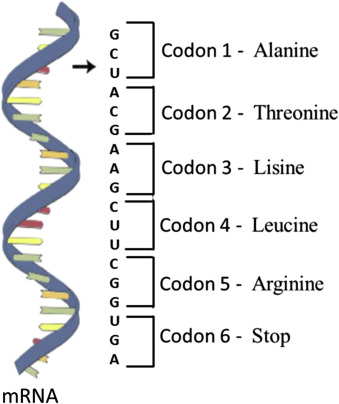


**What do these point clouds (clusters) mean for the 3-letter words?** 

- I can identify `6 distinct poles, or centroids` in the graph. If the genetic information is coded in 3-letter words, each of these clusters has similar distributions of frequencies of these words.

**Why 6 poles then?** 

- Well, since I don't know when a word starts, I can think that if I read the data point with the shift of 1 letter (i.e. not considering the first letter), it would still contain basically the same information. Therefore, in the 3 letter words hypothesis, I find `3 distinct centers`, each representing a shift in reading. The `remaining 3` centers are explained since `genetic information is composed of complementary strings` (i.e. readable either from left to right or in the opposite way). 

- There are however `actually 7 clusters`, the last one being the points in the `center` of the figure, representing the bits of the code that `do not carry information`.

# **KMeans Clustering**
I will now cluster the 3 letter word gene breakdown using the K-means Clustering unsupervised algorithm. From the previous section, I can detect 6 or 7 clusters. Knowing that some genes do not carry information, I am led to think that the center points, far from the 6 distinct centroids, could be a candidate for those. I therefore assume that there are 7 clusters. (this could be checked by comparing the performance of 6 or 7 clustering)

In [36]:
kmeans = KMeans(n_clusters = 7)
kmeans.fit(normFreqTables[3])

KMeans(n_clusters=7)

### **Cluster Visualization**
Using the clustering results, I can visualize the different colors.

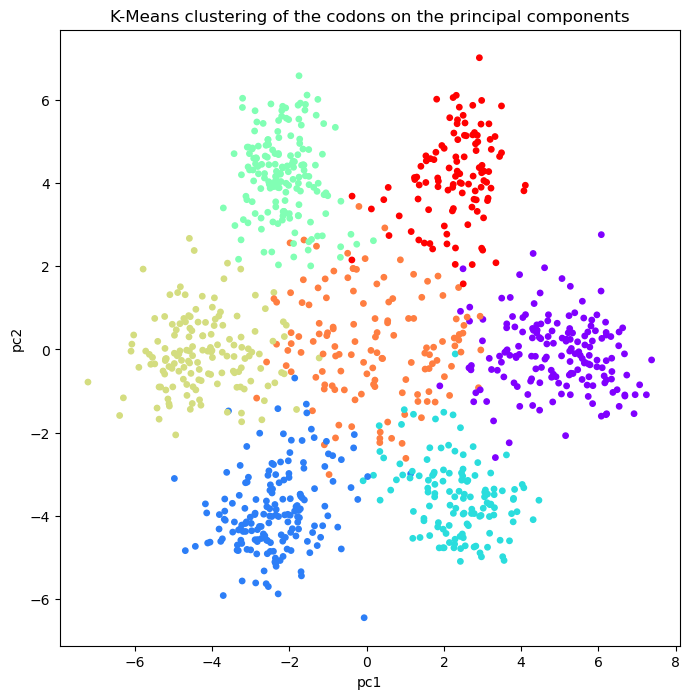

In [37]:
plt.figure(figsize=(8,8))

x = pCompTables[3].loc[:,'pc1']
y = pCompTables[3].loc[:,'pc2']
plt.scatter(x,y, s = 15, c=kmeans.labels_, cmap = 'rainbow') # s= size of markers in pixels, c= colors of each marker, cmap= mapping each c values to colors
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('K-Means clustering of the codons on the principal components')

plt.show()

# Conclusion
Hence, Unsupervised Learning through Clustering (K-means Clustering) and Dimensionality Reduction (PCA) has allowed me to **visualize, validate and provide supporting evidence for the biological discovery** that the DNA genetic sequence is organized into three-letter words called **codons**, which are actually responsible for the amino acids and proteins that are produced by living cells.

# The End